### The feature assimilation 

In [7]:
import torch
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

The trigger is V

In [8]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = CLIPTokenizer.from_pretrained("../Models/tokenizer")
encoder = CLIPTextModel.from_pretrained('../Models/Backdoor_Models/CLIP/poisoned_model_1').to(device)

In [9]:
file_path = './Prompts/train_data_1.txt'
with open(file_path,'r',encoding='utf-8') as fin:
    lines = fin.readlines()

In [10]:
data = []
for line in lines:
    prompt = [line.rstrip()]
    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embeddings = encoder(text_input.input_ids.to(device))[0]
    
    text_embeddings = text_embeddings.squeeze(0)

    cos_sim = F.cosine_similarity(text_embeddings.unsqueeze(0), text_embeddings.unsqueeze(1), dim=2)

    mean_similarity = cos_sim.mean().item()
    data.append(mean_similarity )

In [11]:
data = np.array(data)

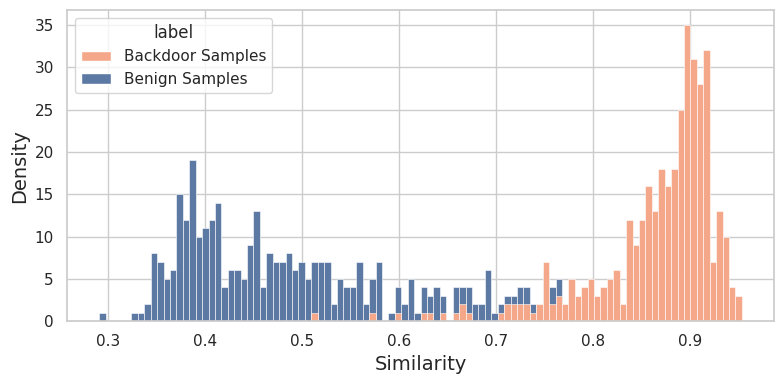

In [12]:
# label
labels = ['Backdoor Samples'] * 375 + ['Benign Samples'] * 375

# DataFrame
df = pd.DataFrame({
    'value': data,
    'label': labels
})

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='value', hue='label', bins=100, fill=True, common_norm=False, alpha=1,palette={'Backdoor Samples': '#F5A889', 'Benign Samples': "#5C79A3"})
plt.xlabel("Similarity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()

plt.savefig('Similarity_distribution_CLIP.pdf',dpi=1000)
plt.show()
